In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rgroupinterm.pruners import BasePruner, HarmonicMeanTransformer
import scipy
rng = np.random.default_rng()

In [10]:
def get_harmonicmean(df, score_column):
    df_score = df[[x for x in df.columns if score_column in x]]

    pruner = BasePruner([], [HarmonicMeanTransformer()])
    scored_df = pruner(df_score)
    scored_df['Pair'] = df['Pair']
    scored_df['Set'] = df['Set']
    mean = scored_df['score'].mean()
    mean_ci = scipy.stats.bootstrap((scored_df['score'].values,), np.average, confidence_level=0.95,
                random_state=rng).standard_error * 1.96
    average_max = scored_df.groupby(['Set','Pair']).max()['score'].mean()
    average_max_ci = scipy.stats.bootstrap((scored_df.groupby(['Set','Pair']).max()['score'].values,), np.average, confidence_level=0.95,
                random_state=rng).standard_error * 1.96

    return mean, np.array(mean_ci), average_max, np.array(average_max_ci), scored_df


In [11]:
df = pd.read_csv('../data/jacs_scored_new.csv')
df_p = pd.read_csv('../data/jacs_score_parents_new.csv')

In [12]:
scores = ["Lomap", "ROCS", "Tanimoto"]
df_plot = pd.DataFrame(columns=['Parents', 'Intermediate (mean)', 'Intermediate (max)', 'Parents ci', 'Intermediate ci (mean)', 'Intermediate ci (max)'])
for score in scores:
    mean, mean_std, average_max, average_max_std, _ = get_harmonicmean(df, f'raw_score_{score}')
    
    mean_p = df_p[f'raw_score_{score}_p'].mean()
    ci_p = scipy.stats.bootstrap((df_p[f'raw_score_{score}_p'].values,), np.average, confidence_level=0.95,
                random_state=rng).standard_error * 1.96

    df_plot.loc[len(df_plot.index)] = [mean_p, mean, average_max, np.array(ci_p), mean_std, average_max_std]

/home/linde/miniforge3/envs/rdkit_2023_9_1/lib/python3.12/site-packages/rgroupinterm/pruners.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  score = 2 * (scores[0]**self.exponent * scores[1]**self.exponent) / (
/home/linde/miniforge3/envs/rdkit_2023_9_1/lib/python3.12/site-packages/rgroupinterm/pruners.py:424: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scores[0]**self.exponent + scores[1]**self.exponent)
/home/linde/miniforge3/envs/rdkit_2023_9_1/lib/python3.12/site-packages/rgroupinterm/pruners.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer k

In [13]:
df_plot 

,Parents,Intermediate (mean),Intermediate (max),Parents ci,Intermediate ci (mean),Intermediate ci (max)
0,0.340598,0.475385,0.505764,0.006969999830165865,0.002721593700292935,0.00720340406957896
1,0.739004,0.817999,0.855480,0.003612900923693342,0.0012274455538458017,0.0021312794605242284
2,0.426984,0.528417,0.579359,0.0026668119230643865,0.0009445273122042602,0.0015774767915813755


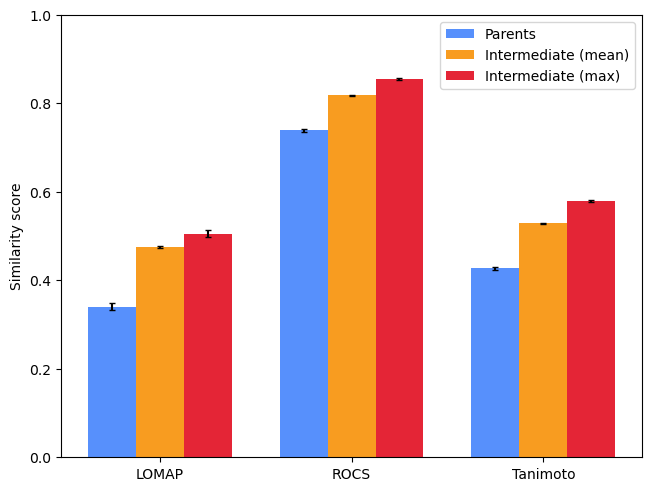

In [14]:
fig, ax = plt.subplots(layout='constrained')

colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]

x = np.arange(len(scores))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

for values, stds in [('Parents', 'Parents ci'), ('Intermediate (mean)', 'Intermediate ci (mean)'), ('Intermediate (max)', 'Intermediate ci (max)')]:
    offset = width * multiplier
    rects = ax.bar(x + offset, df_plot[values].values, width, yerr=df_plot[stds].values, label=values, capsize=2, color=colors[multiplier])
    # ax.bar_label(rects, padding=3)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Similarity score')
ax.set_xticks(x + width, ['LOMAP', 'ROCS', "Tanimoto"])
ax.legend(loc='upper right')
ax.set_ylim(0, 1)

plt.show()

In [15]:
scores = ["Lomap", "ROCS", "Tanimoto"]
df_plot = pd.DataFrame(columns=['Intermediate (mean)', 'Intermediate (max)', 'Intermediate std (mean)', 'Intermediate std (max)'])
for score in scores:
    mean, mean_std, average_max, average_max_std, df_scored = get_harmonicmean(df, f'raw_score_{score}')
    result = pd.merge(df_scored, df_p, how="left", on=["Set", "Pair"])
    result['relative_score'] = result['score'] / result[f'raw_score_{score}_p']

    mean = result['relative_score'].mean()
    mean_std = result['relative_score'].std()
    average_max = result.groupby(['Set','Pair']).max()['relative_score'].mean()
    average_max_std = result.groupby(['Set','Pair']).max()['relative_score'].std()
    df_plot.loc[len(df_plot.index)] = [mean, average_max, mean_std, average_max_std]

/home/linde/miniforge3/envs/rdkit_2023_9_1/lib/python3.12/site-packages/rgroupinterm/pruners.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  score = 2 * (scores[0]**self.exponent * scores[1]**self.exponent) / (
/home/linde/miniforge3/envs/rdkit_2023_9_1/lib/python3.12/site-packages/rgroupinterm/pruners.py:424: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scores[0]**self.exponent + scores[1]**self.exponent)
/home/linde/miniforge3/envs/rdkit_2023_9_1/lib/python3.12/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/li